In [1]:
!pip install scratchai-nightly  # for adversarial attack
!pip install torchvision==0.9.1 # deep learning models
!pip install flashtorch         # visualization based on activation maximization
!pip install mapextrackt        # visualization of neural network saliency map
!pip install tqdm
!pip install requests
!pip install opencv-python
!pip install scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 2.8 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement torch==1.8.1 (from versions: 2.2.0, 2.2.1, 2.2.2, 2.3.0, 2.3.1, 2.4.0, 2.4.1, 2.5.0, 2.5.1, 2.6.0, 2.7.0, 2.7.1, 2.8.0)
ERROR: No matching distribution found for torch==1.8.1
  Preparing metadata (setup.py) ... done
  Created wheel for flashtorch: filename=flashtorch-0.1.3-py3-none-any.whl size=26228 sha256=3b82695a616787659c4df0d32dfa9050b8065c19d7e7b05aa335d79de5f34d1b
  Stored in directory: /root/.cache/pip/wheels/c0/cb/5a/9c2b300f5b071f152ae77000d76a7d8dc58fdba7b3fef05afe
Successfully built flashtorch


In [1]:
# download and store locally a stop sign image
stop_sign_url = 'https://static01.nyt.com/images/2011/12/11/magazine/11wmt1/mag-11WMT-t_CA0-jumbo.jpg'
!mkdir input_images
!wget https://static01.nyt.com/images/2011/12/11/magazine/11wmt1/mag-11WMT-t_CA0-jumbo.jpg -O input_images/stop.jpg

--2025-08-29 17:27:47--  https://static01.nyt.com/images/2011/12/11/magazine/11wmt1/mag-11WMT-t_CA0-jumbo.jpg
Resolving static01.nyt.com (static01.nyt.com)... 146.75.37.164
Connecting to static01.nyt.com (static01.nyt.com)|146.75.37.164|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 92066 (90K) [image/jpeg]
Saving to: ‘input_images/stop.jpg’

input_images/stop.j 100%[===================>]  89.91K  --.-KB/s    in 0.04s   

2025-08-29 17:27:47 (2.50 MB/s) - ‘input_images/stop.jpg’ saved [92066/92066]



In [1]:
# suppress error
import logging as logging
import sys as sys
logging.disable(sys.maxsize)

# import the library
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models
from scratchai import *

from flashtorch.activmax import GradientAscent
from MapExtrackt import FeatureExtractor
from torch.distributions import Normal


# set parameters
stop_sign_path = 'input_images/stop.jpg' #stop sign image path
true_class = 919 # imagenet id for street sign


# function handle to get prediction more easily
def get_prediction(image, model):
    #assumes img and net are datasets and models trained using imagenet dataset
    confidences = model(image.unsqueeze(0))
    class_idx = torch.argmax(confidences, dim=1).item()
    class_label = datasets.labels.imagenet_labels[class_idx]
    return class_label, confidences[0, class_idx].item(), class_idx

In [2]:
'''Added cell to check torch and cuda version'''
print('Torch version:', torch.__version__)
device = "cuda" if torch.cuda.is_available() else "cpu"
print('Device:', device)

Torch version: 2.8.0+cu128
Device: cuda


**1a: Making prediction**

In [3]:
# load and preprocess the stop sign image
img = imgutils.load_img(stop_sign_path)
img = imgutils.get_trf('rz256_cc224_tt_normimgnet')(img) #normalize and reshape the input image

'''
These input loaders above are provided by scratchai library.

imgutils is a scratchai utility to load and preprocess images.

rz256_cc224_tt_normimgnet means:
- resize the shorter side to 256 pixels
- center crop to 224x224 pixels
- normalize using the mean and standard deviation of ImageNet dataset
'''
img = img.to('cuda').type(torch.cuda.FloatTensor) # move image input to GPU

# Load pretrained ResNet-18 model
'''
This is what the cell is looking for but this has been deprecated
net = models.resnet18(pretrained=True).to("cuda").eval()
'''
# Loading the ResNet-18 model using the updated method
weights = models.ResNet18_Weights.DEFAULT
net = models.resnet18(weights=weights).to("cuda").eval()

# use the provided get_prediction function to predict the class of the stop sign image
pred_label, pred_conf, pred_idx = get_prediction(img, net)
print(f"Predicted label: {pred_label}, Confidence: {pred_conf:.4f}, Class index: {pred_idx}")

Predicted label: street sign, Confidence: 13.5563, Class index: 919


**1b: Random perturbation**

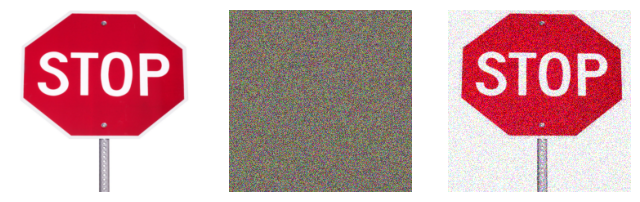

Image 0: True label=919, Predicted label=street sign, Confidence=13.5563, Class index=919
Image 1: True label=919, Predicted label=nematode, nematode worm, roundworm, Confidence=5.1732, Class index=111
Image 2: True label=919, Predicted label=doormat, welcome mat, Confidence=16.5983, Class index=539


In [36]:
# REPLACE THE THREE DOTS WITH YOUR OWN CODE

epsilon = 1 # set the epsilon

torch.manual_seed(0) # set the random seed when you use functions that uses sampling

noisy_img = attacks.noise(img, eps=epsilon)
# perform uniform random attack here [see the example in the Sec. 3.2.4 of the problem set]

pred, conf, label_id = get_prediction(image=img.cuda(),model=net) # output prediction, conf, and label_id using get_prediction function

img = img.cpu()
noisy_img = noisy_img.cpu()
imgutils.imshow([img.cpu(), noisy_img-img, noisy_img], normd=True) #output the original image, the perturbation image, the perturbed image

# Compute and print true and predicted labels for each image
labels = []
images = [img, noisy_img - img, noisy_img]
for image in images:
    pred_label, pred_conf, pred_idx = get_prediction(image.cuda(), net)
    labels.append((true_class, pred_label, pred_conf, pred_idx))

for i, (true_label, predicted_label, confidence, idx) in enumerate(labels):
    print(f"Image {i}: True label={true_label}, Predicted label={predicted_label}, Confidence={confidence:.4f}, Class index={idx}")


**1c: FGM Attack**

<class 'torch.Tensor'>
torch.Size([3, 224, 224])


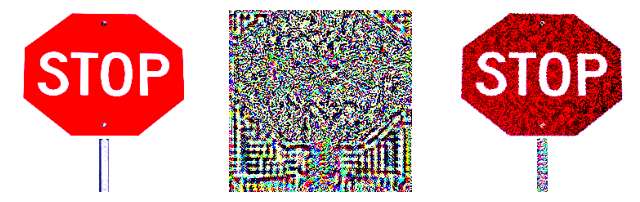

Image 0: True label=919, Predicted label=street sign, Confidence=13.5563, Class index=919
Image 1: True label=919, Predicted label=prayer rug, prayer mat, Confidence=11.5818, Class index=741
Image 2: True label=919, Predicted label=digital clock, Confidence=10.6214, Class index=530


In [ ]:
# REPLACE THE THREE DOTS WITH YOUR OWN CODE
# Don't forget to pass in true_class established in the beginning for the stop signs (919) and make it a tensor since you're trying to use cuda
'''
Provided code implementation is incorrect as the fgm attack code located here:
https://github.com/iArunava/scratchai/blob/master/scratchai/attacks/attacks/fast_gradient_method.py
specifically states in the dosctring that the function only 1 image:
Returns
-------
adv_x : torch.Tensor
    The adversarial example.

Which means that all 3 images need to be provided by and an images list needs to be created
and you also need to get rid of the true_labels and predicted_labels variables since they are not returned
and mess up passing the image in imgutils.imshow(images)

images, true_labels, predicted_labels = ... # is completely wrong for the attacks.fgm() function
'''
adv_img = attacks.fgm(img.cuda(), net.cuda(), eps=epsilon, y=torch.tensor([true_class], device=img.device).cuda()) # perform FGM attacks and return all the outputs
'''
This is a really cool library, but don't forget that you also learned how
to implement FGSM attack and iterate it directly in ML with Adversaries in mind.
github repo: aitechroberts/ml_adversary HW3 about mid way.
'''
# Keeping the types to show how I debugged the above problem
print(type(adv_img))
print(adv_img.shape)
perturbation = (adv_img.cpu() - img) # calculate the perturbation
images = [img, perturbation, adv_img.cpu()]
imgutils.imshow(images) # show all the images [original, perturbation, and adversarial]

'''
code for seeing the true labels and predicted labels of each image using same capability as previously provided
with get_prediction function
'''

labels = []
for image in images:
    pred_label, pred_conf, pred_idx = get_prediction(image.cuda(), net)
    labels.append((true_class, pred_label, pred_conf, pred_idx))

for i, (true_label, predicted_label, confidence, idx) in enumerate(labels):
    print(f"Image {i}: True label={true_label}, Predicted label={predicted_label}, Confidence={confidence:.4f}, Class index={idx}")

# true_labels, predicted_labels # show true and predicted labels

**1d: PGD Attack**

<class 'torch.Tensor'>
torch.Size([3, 224, 224])


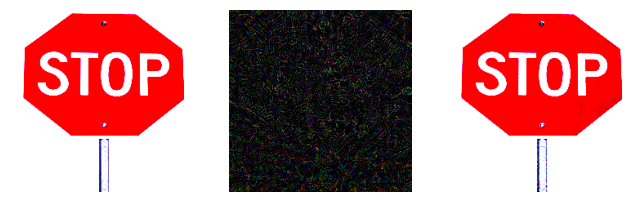

Original Image: True label=829, Predicted label=street sign, Confidence=13.5563, Class index=919
Perturbation: True label=829, Predicted label=spider web, spider's web, Confidence=10.0202, Class index=815
Adversarial Image: True label=829, Predicted label=streetcar, tram, tramcar, trolley, trolley car, Confidence=29.6087, Class index=829


In [44]:
# REPLACE THE THREE DOTS WITH YOUR OWN CODE

target_class = 829 # imagenet id for street car

# REPLACE THE THREE DOTS WITH YOUR OWN CODE
# Don't forget to pass in true_class established in the beginning for the stop signs (919) and make it a tensor since you're trying to use cuda
'''
Same as above. PGD attack returns adversarial image only and not a list of images
'''
pgd_img = attacks.pgd(img.cuda(), net.cuda(), targeted=True, eps=epsilon, y=torch.tensor([target_class], device=img.device).cuda()) # perform FGM attacks and return all the outputs
'''
This is a really cool library, but don't forget that you also learned how
to implement FGSM attack and iterate it directly in ML with Adversaries in mind.
github repo: aitechroberts/ml_adversary HW3 about mid way.
'''
# Keeping the types to show how I debugged the above problem
print(type(pgd_img))
print(pgd_img.shape)
perturbation = (pgd_img.cpu() - img) # calculate the perturbation
images = [img, perturbation, pgd_img.cpu()]
imgutils.imshow(images) # show all the images [original, perturbation, and adversarial]

'''
code for seeing the true labels and predicted labels of each image using same capability as previously provided
with get_prediction function
'''

labels = []
images_types = ["Original Image", "Perturbation", "Adversarial Image"]
for image in images:
    pred_label, pred_conf, pred_idx = get_prediction(image.cuda(), net)
    labels.append((target_class, pred_label, pred_conf, pred_idx))

for i, (target_label, predicted_label, confidence, idx) in enumerate(labels):
    imtype = images_types[i] if i < len(images_types) else f"Image {i}"
    print(f"{imtype}: True label={target_label}, Predicted label={predicted_label}, Confidence={confidence:.4f}, Class index={idx}")

# true_labels, predicted_labels # show true and predicted labels

**2a: AlexNet layer 0 visualization**

In [42]:
# REPLACE THE THREE DOTS WITH YOUR OWN CODE
# Again using the non-deprecated method to load the pretrained AlexNet model
weights = models.AlexNet_Weights.DEFAULT
model = models.alexnet(weights=weights)

print(model) # show the alexnet structure

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /home/jroberts/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:05<00:00, 44.0MB/s] 



AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
# REPLACE THE THREE DOTS WITH YOUR OWN CODE

#load GradientAscent on GPU
g_ascent = GradientAscent(model.features)
g_ascent.use_gpu = True

layer_idx = ... # set the layer index

filters = ... # set the filter numbers

layer = model.features[layer_idx] # select the 1st conv layer

... # call g_ascent.visualize() with the correct arguments to output the visualization



**2b: AlexNet layer 10 visualization**

In [ ]:
# MODIFY THE CODE FOR 2a TO VISUALIZE LAYER 10, FILTERS [5, 10, 15, 20] OF ALEXNET


**2c: AlexNet saliency map with the stop sign image**

In [ ]:
# REPLACE THE THREE DOTS WITH YOUR OWN CODE

# load FeatureExtractor
from MapExtrackt import FeatureExtractor

layer_idx = ... #define the layer index

fe = FeatureExtractor(model)

fe.set_image(stop_sign_path) # stop_sign_path is the path to the stop sign image

fe.display_from_map(layer_no=layer_idx)

**3: Example of plot with a confidence interval**



In [ ]:
#THIS IS JUST AN EXAMPLE TO PLOT CONFIDENCE INTERVAL AS SHADED AREA

n = 500 # number of samples
k = 10  # number of replications
sigma = 0.2

torch.manual_seed(0) # set the random seed
deltas = torch.FloatTensor(sigma*torch.randn(n, k)) # gaussian samples ~ N(0, sigma*I)

# compute mean and standard deviation
mean_ = deltas.mean(dim=0)
std_ = deltas.std(dim=0)

# generate the plot
x = np.arange(k) # populate x axis
plt.plot(x, mean_, label="Estimated mean of $\delta$")
plt.fill_between(x, mean_ - std_, mean_ + std_, alpha=0.5, label="Confidence Interval") # 1-sigma confidence interval
plt.legend()
plt.ylim([None, 0.4])
plt.title('Example plot')
plt.show()

**Density computation example with log_prob**

In [ ]:
# THIS IS AN EXAMPLE TO USE log_prob METHOD FOR EASIER DENSITY COMPUTATION

# Suppose you want to compute the density of Normal distribution

# create Normal distribution object
p = Normal(torch.tensor([0.0]), torch.tensor([sigma]))       # N(0, sigma**2)
p_tilde = Normal(torch.tensor([0.2]), torch.tensor([sigma])) # N(1, sigma**2)

# use log_prob method
log_density_orig = p.log_prob(deltas) # log_prob method gives you log densities
log_density_tilde = p_tilde.log_prob(deltas)

# verify this by plotting the density, i.e. the exp of the log_density
plt.scatter(deltas, torch.exp(log_lkl_orig), label="p")
plt.scatter(deltas, torch.exp(log_lkl_tilde), label="p_tilde")
plt.show()

**3a: MC estimator for prob. robustness of ResNet-18**

In [ ]:
# REPLACE THE THREE DOTS WITH YOUR OWN CODE

net = ... # load resnet

sigma_squared = # parameter sigma

# evaluate the model k times, each time use n samples
k = ... # number of replications
n = ... # number of samples in each replication

# collect the samples
torch.manual_seed(0) # set the random seed
deltas = torch.FloatTensor(sigma_squared*torch.randn(*img.shape, n, k)) # gaussian samples ~ N(0, sigma**2*I)

resnet_test=np.zeros([n, k])

for i in range(k):
    for j in range(n):
        noisy_img = img + deltas[:, :, :, j, i]
        _, _, y_i = get_prediction(noisy_img, net)
        resnet_test[j, i] = y_i != true_class

In [ ]:
# compute the mean and standard deviation of your estimator
mu_hat_n_samples = resnet_test.mean(axis=0)

mean_ = mu_hat_n_samples.mean()
std_ = mu_hat_n_samples.std()

mean_, std_

In [ ]:
# REPEAT THE ABOVE EXAMPLE FOR n = [50, 100, 150, ..., 500]
...

# PLOT THE MEAN AND THE CONFIDENCE INTERVAL OF THE k VALUES OF mu_hat_n VS n
...

**3b: MC relative error**

In [ ]:
# REPLACE THE THREE DOTS WITH YOUR OWN CODE

mu = 0.03 #true mu value

relative_error = ... # compute the relative error

# PLOT THE RELATIVE ERROR VS n
...

**3c: Misclassification rate w.r.t. samples close to an adversarial example**

In [ ]:
# REPLACE THE THREE DOTS WITH YOUR OWN CODE

# repeat the FGM attack from problem 1c
xtilde = ...

# perform mean shift, closer to the adversarial example
scale = 1/3
mean_shift = scale*xtilde

# generate Gaussian samples centered at the mean_shift
torch.manual_seed(0) # set the random seed

deltas = ...

# compute misclassification rate using this new deltas, similar to 3a above
...